# Broadcast simulator using UDP
In this simulator, I will create a broadcaster and a listener, that waits for $N$ packets. After $N$ received packets, the receiver will decode the message.

This setup uses User Datagram Protocol (UDP) sockets. In contrast with TCP, packets over UDP will not always be delivered in the transmitted order. Also, UDP has no verification mechanism to check if a package has arrived. UDP is often used when speed is more important than a 100\% error-less connection, like sending live voice or video streaming. Since this network runs on the local machine, I expect no packet loss. However, since we use Fountain Codes to decode the message, it does not matter if we lose packets, since we wait until we have $N$ packets.

In [125]:
import socket, random, time, threading, statistics, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Increase limit for socket files

In [126]:
! ulimit -n 4096

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


We will first define the symbol. A drop consists of a symbol, which contains data and metadata (header information) like the number of blocks it contains, the degree and the index. 

In [127]:
class Symbol:
    
    __slots__ = ["index", "degree", "data", "neighbors", "blocks_n"]

    def __init__(self, index, degree, data,blocks_n):
        self.index = index
        self.degree = degree
        self.data = data
        self.blocks_n = blocks_n
    
    def to_bytes(self):
        return str(str(self.index) + "|" +  str(self.degree) + "|" + str(list(self.data)) + "|" + str(self.blocks_n)).encode()


### Encoding
First, the encoder is defined. The encoder will encode the message into a given amount of drops.
Since computating Fountain codes is not expensive (same holds for sending messages on our socket), we will compute and send drops_quantity (K') drops.

In [128]:
class FountainEncoder():
    
    def __init__(self,BLOCK_SIZE=10):
        self.BLOCK_SIZE = BLOCK_SIZE

    
    def generate_indexes(self,symbol_index, degree, blocks_quantity):
        """
        Randomly get `degree` indexes, given the symbol index as a seed
        Generating with a seed allows saving only the seed (and the amount of degrees) 
        and not the whole array of indexes. That saves memory, but also bandwidth when paquets are sent.
        The random indexes need to be unique because the decoding process uses dictionnaries for performance enhancements.
        Additionnally, even if XORing one block with itself among with other is not a problem for the algorithm, 
        it is better to avoid uneffective operations like that.
        To be sure to get the same random indexes, we need to pass 
        """
        if symbol_index < blocks_quantity:
            indexes = [symbol_index]               
            degree = 1     
        else:
            random.seed(symbol_index)
            indexes = random.sample(range(blocks_quantity), degree)

        return indexes, degree


    def get_degrees(self,N, k):
        """ 
        Returns the random degrees from the distribution.
        The degrees distribution must look like a Poisson distribution and the 
        degree of the first drop is 1 to ensure the start of decoding.
        """
        probabilities = p = [0,1/N] + [1/(k*(k-1)) for k in range(2,N+1)] # p(k) = 1/N if k == 1 else 1/(k(k-1))
        population = list(range(0, N+1))
        return [1] + random.choices(population, probabilities, k=k-1)
   
    def to_blocks(self,message):
        """
        Converts string to blocks , list of type bytearray
        """
        blocks = []
        for i in range(0, len(message), self.BLOCK_SIZE):
            blocks.append(bytearray(message[i:i+self.BLOCK_SIZE],   'utf-8'))
        return blocks


    def encode(self,message,drops_quantity):
        """
        Encode the message into drops_quantity "drops"
        """
        blocks = self.to_blocks(message)
        blocks_n = len(blocks)

        random_degrees = self.get_degrees(blocks_n,drops_quantity)
        
        drops = []
        for i in range(drops_quantity):

            # Get the random selection
            selection_indexes, deg = self.generate_indexes(i, random_degrees[i], blocks_n)

            drop = blocks[selection_indexes[0]]
            for n in range(1, deg):
                # do bitwise XOR 
                try:
                    drop = np.bitwise_xor(drop, blocks[selection_indexes[n]])
                except:
                    #error bitwise xor
                    deg = deg-1
                    continue
            symbol = Symbol(index=i, degree=deg, data=drop, blocks_n=blocks_n)

            drops.append(symbol)

        return drops
    


### Decoding

Decoding is done in the following process: 

We loop trough the symbols, to find a symbol with degree 1. We set the value of the corresponding block to the value of this symbol. After that, we remove the symbol from the list of symbols. Then we use a bitwise XOR to update the corresponding symbols of the block, and remove the edges between the symbols and the block.





In [129]:
class FountainDecoder():
    
    def __init__(self,BLOCK_SIZE=10):
        self.BLOCK_SIZE = BLOCK_SIZE
    
    def recover_graph(self,symbols, blocks_quantity):
        """ 
        Get back the same random indexes (or neighbors), thanks to the symbol id as seed.
        For an easy implementation purpose, we register the indexes as property of the Symbols objects.
        """
        for symbol in symbols:

            neighbors, deg = self.generate_indexes(symbol.index, symbol.degree, blocks_quantity)
            symbol.neighbors = {x for x in neighbors}
            symbol.degree = deg
        return symbols
    
    def reduce_neighbors(self,block_index, blocks, symbols):
        """ 
        Loop over the remaining symbols to find for a common link between 
        each symbol and the last solved block `block`
        To avoid increasing complexity and another for loop, the neighbors are stored as dictionnary
        which enable to directly delete the entry after XORing back.
        """

        for other_symbol in symbols:
            if other_symbol.degree > 1 and block_index in other_symbol.neighbors:
                try:
                    # XOR the data and remove the index from the neighbors
                    other_symbol.data = np.bitwise_xor(blocks[block_index], other_symbol.data)
                    other_symbol.neighbors.remove(block_index)
                    other_symbol.degree -= 1
                except:
                    continue
        
    def generate_indexes(self,symbol_index, degree, blocks_quantity):
        """
        Same as encoder
        """
        if symbol_index < blocks_quantity:
            indexes = [symbol_index]               
            degree = 1     
        else:
            random.seed(symbol_index)
            indexes = random.sample(range(blocks_quantity), degree)

        return indexes, degree
    
    def get_message_from_blocks(self, blocks):
        """
        Converts blocks to string
        """
        self.message = ""
        for block in blocks:
            self.message += bytearray(block).decode("utf-8")
        
        return self.message

    
    def decode(self, drops):
        
        symbols_n = len(drops)
        blocks_n = drops[0].blocks_n
        blocks = [None] * blocks_n

        # Recover the degrees and associated neighbors using the seed (the index, cf. encoding).
        symbols = self.recover_graph(drops, blocks_n)

        solved_blocks_count = 0
        iteration_solved_count = 0

        while iteration_solved_count > 0 or solved_blocks_count == 0:

            iteration_solved_count = 0
            # Search for solvable symbols
            for i, symbol in enumerate(symbols):
                # Check the current degree. If it's 1 then we can recover data
                if symbol.degree == 1: 
                    iteration_solved_count += 1 
                    block_index = next(iter(symbol.neighbors)) 
                    symbols.pop(i)
                    # This symbol is redundant: another already helped decoding the same block
                    if blocks[block_index] is not None:
                        continue
                    blocks[block_index] = symbol.data
                    # Update the count
                    solved_blocks_count += 1
                    # Reduce the degrees of other symbols that contains the solved block as neighbor             
                    self.reduce_neighbors(block_index, blocks, symbols)


        # Check if message is available:
        for block in blocks:
            if block is None:
                return False
        
        # Restore message from blocks and return
        return self.get_message_from_blocks(blocks)




### Test the encoder+decoder

In [130]:
test_string = str("abcdefghijklmnopqrstuvwxyz"*10)
encoder = FountainEncoder()
drops = encoder.encode(test_string,1000)   
decoder = FountainDecoder()
print("Works fine " if test_string ==  decoder.decode(drops) else "Error")

Works fine 


### Network

The network consists of a broadcaster, several receivers and the network object.


In [132]:
class Broadcaster(threading.Thread):
    """
    The broadcaster server can send packets to the socket
    """
    def __init__(self, UDP_PORT,UDP_IP,*args, **kwargs):
        
        # init threading class
        super(Broadcaster, self).__init__(*args, **kwargs) 
        
        self.message = ""
        
        self.UDP_PORT = UDP_PORT
        self.UPD_IP = UDP_IP
        self.server = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)
        self.server.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
        self.server.settimeout(10)
        self.server.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) #--> SO_REUSEADDR for Linux
    
    def start(self,number_of_drops=0, BLOCK_SIZE=10):
        
        encoder = FountainEncoder(BLOCK_SIZE)
        
        drops = encoder.encode(self.message,number_of_drops)
        for drop in drops:
            self.server.sendto(drop.to_bytes(), ("<broadcast>", self.UDP_PORT))      
        self.server.close()
        return

In [133]:
class Receiver(threading.Thread): 
    """
    A network can have multiple receivers. Receivers listen on the socket to find new packets.
    """
    def __init__(self, N, name, UDP_PORT, UDP_IP,*args, **kwargs): 
        # init threading class
        super(Receiver, self).__init__(*args, **kwargs) 
        self._stop = threading.Event() 
        self.name = str(name)
        self.N = N
        self.UDP_PORT = UDP_PORT
        self.UDP_IP = UDP_IP
        self.symbols_received = []
        
        # Statistics
        self.restored = False
        self.restore_time_seconds = 0
        self.result = ""
        self.got_till_end = False
        
        # init client
        self.client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)
        self.client.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.client.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
        self.client.bind(("", self.UDP_PORT))
        
    def stop(self): 
        self._stop.set() 
  
    def stopped(self): 
        return self._stop.isSet() 
  
    def run(self): 
        # Wait until N messages received
        
        start = 0
        
        while True: 
            if self.stopped(): 
                return
            
            packet,_ = self.client.recvfrom(1024)
            
            if len(self.symbols_received) == 0:
                start = time.time() # first packet, start timer 
            
            # convert packet to Symbol
            packet = str(packet)[2:-1].split("|")
            packet[2] = np.array([int(z) for z in packet[2][1:-1].split(",")])

            s = Symbol(index=int(packet[0]), degree=int(packet[1]), data=packet[2], blocks_n=int(packet[3]))
            self.symbols_received.append(s)

            if len(self.symbols_received) >= self.N: 
                break
    
        # Decode the packets to find the message
        decoder = FountainDecoder()
        message = decoder.decode(self.symbols_received)
        if not message:
            self.got_till_end = True
            self.client.close()
            return
        message = message.replace('\x00','')
        self.result = message
        self.restored = True
        self.restore_time_seconds = time.time() - start 
        self.got_till_end = True
        # Close socket
        self.client.close()
        
        
        

In [134]:
class Network():
    """
    A network consists of a broadcaster and n (threaded) receivers. 
    The receivers all wait untill N packets have arrived,
    decode the message and stop the thread. 
    """
    def __init__(self,N=10):
        self.receivers = []
        self.UDP_PORT = random.randint(9000, 9500)
        self.UDP_IP = "127.0.0.1"
        self.N = N

    
    def start(self,n,N):
        # n = number of receivers
        # N = number of packets to be received 
        for i in range(n):
            x = Receiver(N,i,self.UDP_PORT, self.UDP_IP)
            x.start()
            self.receivers.append(x)
    
    def stop(self):
        for x in self.receivers:
            x.stop()
        self.receivers = []
        
    def send(self,message,number_of_drops=10,BLOCK_SIZE=10):
        broadcaster = Broadcaster(self.UDP_PORT, self.UDP_IP)
        broadcaster.message = message
        broadcaster.start(number_of_drops,BLOCK_SIZE)



In [135]:
test_string = str("abcdefghijklmnopqrstuvwxyz"*2)
network = Network()
network.start(n=10,N=10)
network.send(test_string)

### Benchmarking
The first benchmark will take a look at the number of packets to send:

In [86]:
test_string = str("abcdefghijklmnopqrstuvwxyz"*200)

# number_of_drops_factors = [1.2,1.4,1.6]
number_of_drops_factors = [round(i,3) for i in np.linspace(1,1.6,50)]
# number_of_drops_to_be_received_factors = [round(i,3) for i in np.linspace(0.6,0.97,25)]

number_of_drops_to_be_received_factors = [0.7,0.9]

saved_statistics = [] 

for i1 in range(len(number_of_drops_factors)):
    #print(i1, len(number_of_drops_factors))
    for i2 in range(len(number_of_drops_to_be_received_factors)):
    #for i2 in range(1):
        for _ in range(4):
            network = Network()
            q = number_of_drops_to_be_received_factors[i2]
            #q =0.7
            number_of_drops_to_send = int(math.ceil(len(test_string)/10) *number_of_drops_factors[i1])
            number_of_drops_to_receive = int((number_of_drops_to_send)*q)

            c = [number_of_drops_to_send,number_of_drops_to_receive]

            network.start(100, number_of_drops_to_receive) # n = number of receivers 

            network.send(test_string,number_of_drops_to_send)

            restored = []
            times = []
            ended = []

            # Check receivers
            for receiver in network.receivers:
                # check if message = input
                restored.append(receiver.restored or receiver.result == test_string)
                times.append(receiver.restore_time_seconds)
                ended.append(receiver.got_till_end)

            # Store statistics
            success_restored = sum([1 for q in restored if q == True])
            endings = sum([1 for q in ended if q == True])
            avg_time = sum(times)/len(times)

            saved_statistics.append(c+[success_restored, avg_time,statistics.stdev(times),endings ])

            time.sleep(5)
        

saved_statistics = pd.DataFrame(saved_statistics, columns=["# Drops", "#Drops' (received treshold)", "restored", "avg_time","std_deviation_time", "Endings"])
saved_statistics

,# Drops,#Drops' (received treshold),restored,avg_time,std_deviation_time,Endings
0,520,364,0,0.000000,0.000000,100
1,520,364,0,0.000000,0.000000,100
2,520,364,0,0.000000,0.000000,100
3,520,364,0,0.000000,0.000000,100
4,520,468,0,0.000000,0.000000,100
...,...,...,...,...,...,...
395,832,582,100,3.876319,0.579763,100
396,832,748,100,5.710565,1.101465,100
397,832,748,100,5.893410,0.954830,100
398,832,748,99,5.502886,0.972875,99


<Figure size 432x288 with 0 Axes>

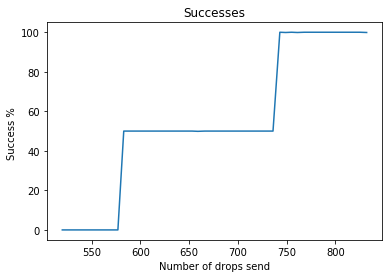

<Figure size 432x288 with 0 Axes>

In [88]:
x,y=[],[]
for i1 in range(len(number_of_drops_factors)):
    #for i2 in range(len(number_of_drops_to_be_received_factors)):
    for i2 in range(1):
        number_of_drops_to_send = int(math.ceil(len(test_string)/10) *number_of_drops_factors[i1])
        
        
        # get avg for number_of_drops_to_receive 
        m = statistics.mean(saved_statistics[saved_statistics["# Drops"] == number_of_drops_to_send]["restored"])
        x.append(number_of_drops_to_send)
        y.append(m)
        
plt.plot(x,y)
plt.title("Successes")
plt.xlabel("Number of drops send")
plt.ylabel("Success % ")
plt.figure()

<Figure size 432x288 with 0 Axes>

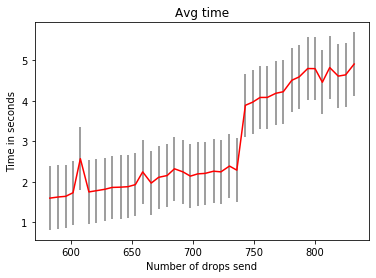

<Figure size 432x288 with 0 Axes>

In [107]:
x,y,s=[],[],[]
for i1 in range(len(number_of_drops_factors)):
    #for i2 in range(len(number_of_drops_to_be_received_factors)):
    for i2 in range(1):
        number_of_drops_to_send = int(math.ceil(len(test_string)/10) *number_of_drops_factors[i1])
        
        # get avg for number_of_drops_to_receive 
        m = statistics.mean(saved_statistics[saved_statistics["# Drops"] == number_of_drops_to_send]["avg_time"])
        s = statistics.mean(saved_statistics[saved_statistics["# Drops"] == number_of_drops_to_send]["std_deviation_time"])
        if m != 0:
            x.append(number_of_drops_to_send)
            y.append(m)

plt.errorbar(x, y, s, linestyle='None', marker='',color="grey")
plt.plot(x,y,color="red")
plt.title("Avg time")
plt.xlabel("Number of drops send")
plt.ylabel("Time in seconds")
plt.figure()

##### Let's find the lowest number of drops with a restored rate of 100%:

In [108]:
saved_statistics[saved_statistics["restored"] == 100].sort_values("# Drops").head(5)

,# Drops,#Drops' (received treshold),restored,avg_time,std_deviation_time,Endings
84,583,524,100,3.234035,0.322205,100
85,583,524,100,3.162429,0.321716,100
86,583,524,100,3.161513,0.350021,100
87,583,524,100,3.250397,0.379388,100
92,590,531,100,3.229947,0.360531,100


In [120]:
# Restore values 
n_drops_send = 583
n_drops_received = 524
number_of_drops_send_factor = n_drops_send/math.ceil(len(test_string)/10)
number_of_drops_receive_factor = round(n_drops_received/n_drops_send,1)


### Test different values for BLOCK_SIZE 

In [148]:
BLOCK_SIZES = [8,9,10,11]

test_string = str("abcdefghijklmnopqrstuvwxyz"*200)

saved_statistics = [] 

for BLOCK_SIZE in BLOCK_SIZES:
    for _ in range(4):
        network = Network()
        q = number_of_drops_receive_factor

        number_of_drops_to_send = int(math.ceil(len(test_string)/10) *number_of_drops_send_factor)
        number_of_drops_to_receive = int((number_of_drops_to_send)*q)

        c = [BLOCK_SIZE]

        network.start(100, number_of_drops_to_receive) # n = number of receivers 

        network.send(test_string,number_of_drops_to_send,BLOCK_SIZE)

        restored = []
        times = []
        ended = []

        # Check receivers
        for receiver in network.receivers:
            # check if message = input
            restored.append(receiver.restored or receiver.result == test_string)
            times.append(receiver.restore_time_seconds)
            ended.append(receiver.got_till_end)

        # Store statistics
        success_restored = sum([1 for q in restored if q == True])
        endings = sum([1 for q in ended if q == True])
        avg_time = sum(times)/len(times)

        saved_statistics.append(c+[success_restored, avg_time,statistics.stdev(times),endings ])

        time.sleep(5)


saved_statistics = pd.DataFrame(saved_statistics, columns=["BLOCK_SIZE", "restored", "avg_time","std_deviation_time", "Endings"])
display(saved_statistics)

,BLOCK_SIZE,restored,avg_time,std_deviation_time,Endings
0,8,0,0.000000,0.000000,100
1,8,0,0.000000,0.000000,100
2,8,0,0.000000,0.000000,100
3,8,0,0.000000,0.000000,100
4,9,0,0.000000,0.000000,100
5,9,0,0.000000,0.000000,100
6,9,0,0.000000,0.000000,100
7,9,0,0.000000,0.000000,100
8,10,100,3.297151,0.342273,100
9,10,100,3.166068,0.377628,100


Text(0.5, 1.0, 'Restored rate vs BLOCK_SIZE')

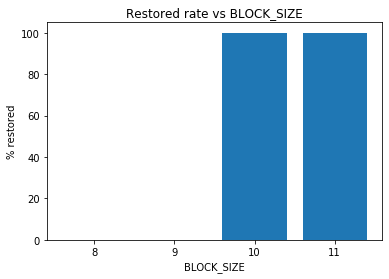

In [147]:
plt.bar(saved_statistics["BLOCK_SIZE"], saved_statistics["restored"])
plt.xticks(saved_statistics["BLOCK_SIZE"])
plt.xlabel("BLOCK_SIZE")
plt.ylabel("% restored")
plt.title("Restored rate vs BLOCK_SIZE")

### Sources:
* (ninedraft 2020), https://github.com/ninedraft/python-udp/
* (Andrieux,2018) https://franpapers.com/en/algorithmic/2018-introduction-to-fountain-codes-lt-codes-with-python/